In [1]:
# load packages
import os
import glob
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import backend
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# path of model checkpoints
checkpoint_path = '../../data/models/20200928_nvidia_ai/'
extracted_coefficients_directory = '../../data/models/extracted_coefficients/20200928_nvidia_ai'
shard_path = '../../data/commaai/test2/'
shard_files = glob.glob(os.path.join(shard_path, "*.tfrecords")) 

In [3]:
shard_files

['../../data/commaai/test2/testshard_test.tfrecords']

In [4]:
# get number of training samples
test_angles_path = '../../data/commaai/test2/testshardyaws.csv'
test_angle = pd.read_csv(test_angles_path, header = None)

In [5]:
np.sum([test_angle[0] > 10])

1212

In [6]:
# benchmark: rmse only zero predictions
rms = sqrt(mean_squared_error(test_angle[0], np.repeat(0, len(test_angle))))
print('rmse of benchmark model (only drive straight): ' + str(rms))
accuracy = np.mean(abs(test_angle[0]) < 6)
print('accuracy of benchmark model (only drive straight): ' + str(accuracy))

rmse of benchmark model (only drive straight): 8.756460728818181
accuracy of benchmark model (only drive straight): 0.9139525021204411


In [7]:
n_test = test_angle.shape[0]
n_test

117900

In [8]:
# build model
Input = tf.keras.layers.Input(shape=(66, 200, 3,), name='image')
x = Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2))(Input)
x = BatchNormalization()(x)
x = Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1164)(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
x = Dropout(0.2)(x)
x = Dense(50)(x) 
x = Dense(10)(x)
Output = Dense(1, name = 'output_layer')(x)

keras_model = tf.keras.models.Model(
      inputs = [Input], outputs = [Output])
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

adam_optimizer = keras.optimizers.Adam(learning_rate=0.0005)
keras_model.load_weights(tf.train.latest_checkpoint(checkpoint_path))
# old
#keras.optimizers.Adadelta(learning_rate = 0.001, rho = 0.95, epsilon = 1e-07, name = 'Adadelta')
keras_model.compile(
    loss = rmse,
    optimizer = adam_optimizer,
    metrics=[rmse, 'mse', 'mae'])


keras_estimator = tf.keras.estimator.model_to_estimator(
      keras_model=keras_model, model_dir = checkpoint_path)

# to inspect weights:
#i = 0 
#for layer in keras_model.layers: 
#    i += 1
#    if i == 16:
#        print(layer.get_config(), layer.get_weights())

# get list of all variables in checkpoint file
# tf.train.list_variables(tf.train.latest_checkpoint(checkpoint_path))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '../../data/models/20200928_nvidia_ai/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [9]:
def imgs_input_fn_val(filenames, perform_shuffle = False, repeat_count = 1, batch_size = 5000): 
    
    # reads in single training example and returns it in a format that the estimator can
    # use
    def _parse_function(proto):
        # define your tfrecord again. Remember that you saved your image as a string.
        keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                            "label": tf.io.FixedLenFeature([], tf.float32),
                            'rows': tf.io.FixedLenFeature([], tf.int64),
                            'cols': tf.io.FixedLenFeature([], tf.int64),
                            'depth': tf.io.FixedLenFeature([], tf.int64)
                           }

        # Load one example
        parsed_example = tf.io.parse_single_example(proto, keys_to_features)

        image_shape = tf.stack([131 , 174, 3])
        image_raw = parsed_example['image']

        label = tf.cast(parsed_example['label'], tf.float32)
        image = tf.io.decode_raw(image_raw, tf.uint8)
        image = tf.cast(image, tf.float32)

        image = tf.reshape(image, image_shape)
        image = tf.image.resize(image[33:99,37:137, :], [66,200])
        image = image/169 

        return {'image':image}, label
    
    dataset = tf.data.TFRecordDataset(filenames = filenames)
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    batch_features, batch_labels = iterator.get_next()
    
    return batch_features, batch_labels

In [10]:
images = []
labels = []
for i in range(0,1):
    image, label = imgs_input_fn_val(shard_files)
    image = np.array(image['image'])
    images.append(image)
    labels.append(np.array(label))
images = np.array(images)
labels = np.array(labels)

In [11]:
images.shape

(1, 5000, 66, 200, 3)

In [12]:
pred = []
for i in tqdm(range(0, images.shape[1])):
    img = images[0,i,:,:,:].reshape(1,66,200, 3)
    single_pred = float(keras_model.predict(img))
    pred.append(single_pred)

100%|██████████| 5000/5000 [03:57<00:00, 21.09it/s]


In [13]:
pred = np.array(pred)

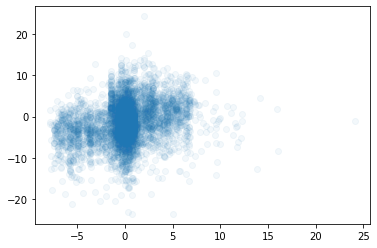

In [14]:
plt.scatter(labels, pred, alpha = 0.05)

In [15]:
labels = labels.reshape(5000)

In [16]:
# benchmark: rmse only zero predictions
rms = sqrt(mean_squared_error(labels, np.repeat(0,len(labels) )))
print('rmse of benchmark model (only drive straight): ' + str(rms))
accuracy = np.mean(abs(labels - np.repeat(0,len(labels) )) < 10)
print('accuracy of benchmark model (only drive straight): ' + str(accuracy))
mse = mean_squared_error(labels, np.repeat(0,len(labels)))
print('mse of benchmark model (only drive straight): ' + str(mse))

rmse of benchmark model (only drive straight): 2.99796297787041
accuracy of benchmark model (only drive straight): 0.996
mse of benchmark model (only drive straight): 8.987782016681617


In [17]:
# benchmark: rmse only zero predictions
rms = sqrt(mean_squared_error(labels, pred))
print('rmse of pilotnet model: ' + str(rms))
accuracy = np.mean(abs(labels - pred) < 10)
print('accuracy of pilotnet model: ' + str(accuracy))
mse = mean_squared_error(labels, pred)
print('mse of pilotnet model: ' + str(mse))

rmse of pilotnet model: 5.292500153836346
accuracy of pilotnet model: 0.9382
mse of pilotnet model: 28.010557878357748


In [ ]:
labels.shape

## Training Performance

In [18]:
shard_path_train = '../../data/commaai/train_files_from_bag_test/'
shard_files_train = glob.glob(os.path.join(shard_path_train, "*.tfrecords")) 

In [19]:
images = []
labels = []
for i in range(0,1):
    image, label = imgs_input_fn_val(shard_files_train)
    image = np.array(image['image'])
    images.append(image)
    labels.append(np.array(label))
images = np.array(images)
labels = np.array(labels)

In [20]:
pred = []
for i in tqdm(range(0, images.shape[1])):
    img = images[0,i,:,:,:].reshape(1,66,200, 3)
    single_pred = float(keras_model.predict(img))
    pred.append(single_pred)
pred = np.array(pred)

100%|██████████| 5000/5000 [03:57<00:00, 21.02it/s]


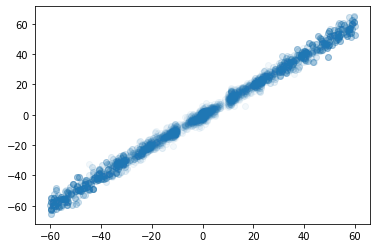

In [21]:
plt.scatter(labels, pred, alpha = 0.05)

In [ ]:
plt.imshow(images[(labels[0] == max(labels[0])),:,:,:].reshape(66,200,3))

In [ ]:
images.shape

In [ ]:
(labels[0] == max(labels[0]))

In [22]:
from keras import models
layer_outputs = [layer.output for layer in keras_model.layers[:12]] 
activation_model = models.Model(inputs=keras_model.input, outputs=layer_outputs) 
activation_model.compile(
    loss = 'mse',
    optimizer=keras.optimizers.Adadelta(learning_rate=0.0005, rho=0.95, epsilon=1e-07, name='Adadelta'),
    metrics=['mse', 'mae'])

In [27]:
images = images.reshape(5000,66,200,3)

In [40]:
pred_cnn = activation_model.predict(images[150].reshape(1,66,200,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


steering angle: -57.0


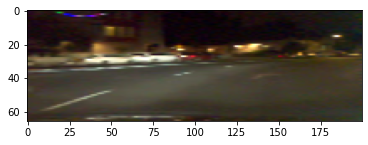

In [37]:
i = 150
plt.imshow(images[i])
print('steering angle: ' + str(labels[0][i]))

In [43]:
pred_cnn[1].shape

(1, 31, 98, 24)

In [44]:
test = pred_cnn[1][:,:,:,11].reshape(31,98)
test2 = pred_cnn[1][:,:,:,12].reshape(31,98)

<ipython-input-45-57e52819ecbc>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f2 = plt.figure(i)


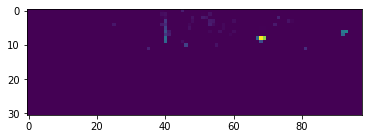

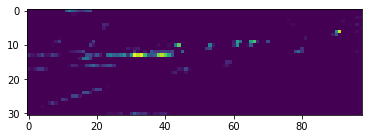

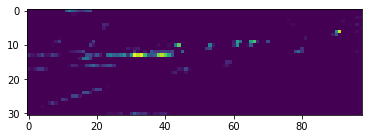

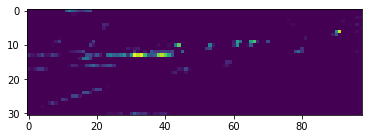

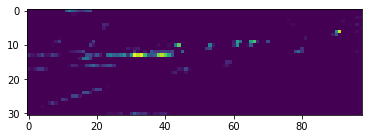

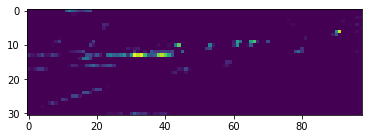

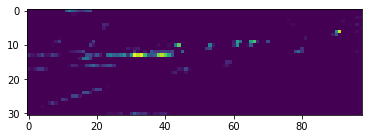

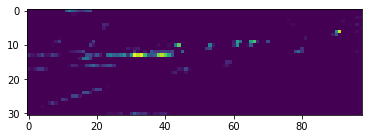

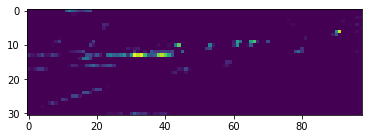

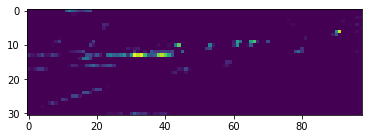

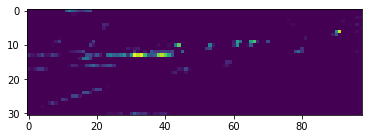

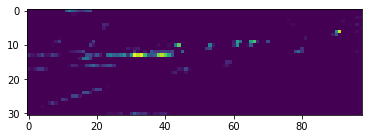

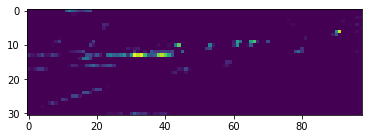

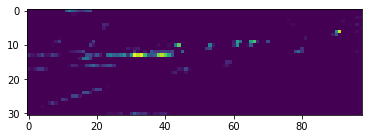

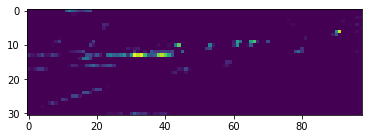

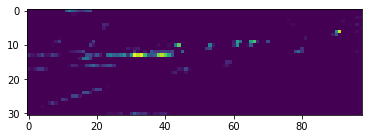

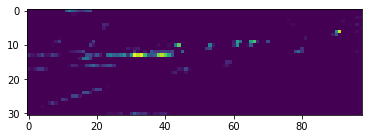

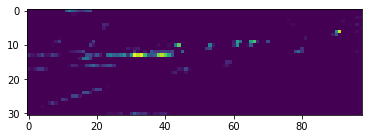

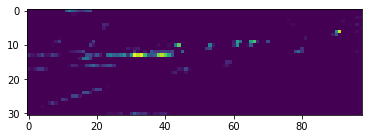

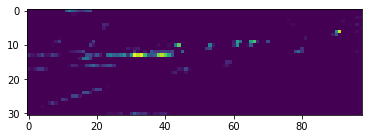

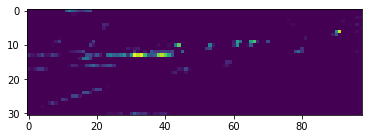

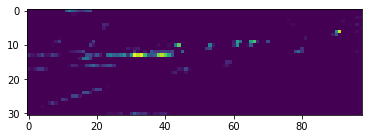

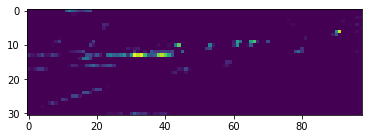

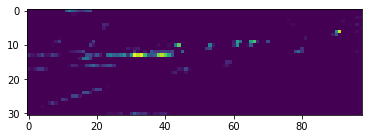

In [45]:
for i in range(0,24):
    f1 = plt.figure(1)
    plt.imshow(test)
    f2 = plt.figure(i)
    plt.imshow(test2)

plt.show()